<a href="https://colab.research.google.com/github/JorgeTonatiuh/aprendizaje_profundo_tarea_2/blob/main/operacion_de_convolucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Operación de convolución

Extiende la operación de convolución para imágenes en escala de grises (un solo canal) a imágenes a color (múltiples canales).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

## Auxiliares

Para utilizar el dataset digits de sklearn, se definirá una función para agregar dos canales a la imagen de escala de grises y transformarla a una imagen ya sea roja o verde.

In [2]:
def color_grayscale_arr(arr, red=True):
  """Convierte imagen de escala de grises a una imagen roja o verde."""
  assert arr.ndim == 2
  dtype = arr.dtype
  h, w = arr.shape
  arr = np.reshape(arr, [h, w, 1])
  if red:
    arr = np.concatenate([arr,
                          np.zeros((h, w, 2), dtype=dtype)], axis=2)
  else:
    arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                          arr,
                          np.zeros((h, w, 1), dtype=dtype)], axis=2)
  return arr

Se define una función para agregar padding a una matriz 2d.

In [3]:
def addPadding(I,p):
  return np.pad(I,[(p, p), (p, p)], mode='constant', constant_values=0)

Se definen funciones para poder hacer un cambio de forma de las matrices de los digitos para representarlas ya sea en Channel first o Channel last.

In [4]:
def reshapeToChannelFirst(x):
  x = np.moveaxis(x, -1, 0)
  return x

def reshapeToChannelLast(x):
  x = np.moveaxis(x, 0, -1)
  return x 

## Carga conjunto de datos de dígitos 
Vamos a cargar el conjunto de datos de dígitos usando la biblioteca `scikit-learn`. Este conjuntos de datos está compuesto por imágenes de $8 \times 8$ de los dígitos $0-9$.

In [5]:
digits = load_digits() 
zeros_ones = digits.target < 2
data = digits.images[zeros_ones]
labels = digits.target[zeros_ones]

Cada elemento del arreglo 'data' tiene ya sea un dígito uno o cero.

In [6]:
data[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Se le agregan los canales necesarios para convertir cada una de las imagenes en escala de grises a imagenes a color ya sea rojas o verdes.

In [7]:
data = np.array([color_grayscale_arr(digit,labels[index]==1) for index,digit in enumerate(data)])

Es conveniente normalizar los valores de las imágenes para que estén en el mismo rango ($0-1$). 

In [8]:
data = data / data.max()

Ahora el conjuntos de datos está compuesto por imágenes de $8 \times 8 \times 3$ de los dígitos $0-9$, los ceros estan en color verde y los unos color rojo. Visualicemos 2 instancias de los dígitos $0$ y $1$:

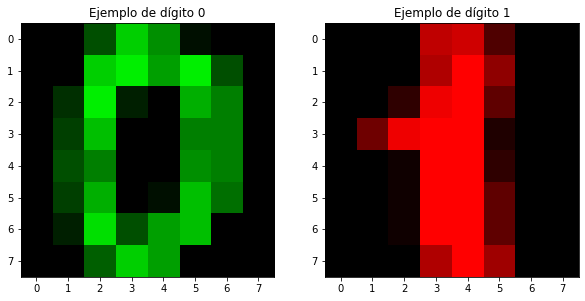

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(data[0])
axs[0].set_title('Ejemplo de dígito 0')
axs[1].imshow(data[1]) 
axs[1].set_title('Ejemplo de dígito 1')
plt.show() 

## Convolución
Ahora consideremos las operación de convolución entre una imagen $I$ y un filtro $W$, la cual está definida por

$$
A_{i,j} = (\mathbf{I} * \mathbf{W})_{i,j} = \sum_m \sum_n I_{m, n} W_{i - m, j - n}
$$

La convolución es commutativa, por lo tanto 

$$
A_{i,j} = (\mathbf{W} * \mathbf{I})_{i,j} = \sum_m \sum_n I_{i - m, j - n} W_{m,n}
$$

El resultado de estas operaciones es el mapa de activaciones $A(i,j)$. 

Para calcular el tamaño de la matriz resultante se utilizaron las siguientes definiciones.

Entrada (channel first): 
$$ C_1 \times H_1 \times W_1 $$

Hiperparámetros:

$K:$ número de filtros, profundidad de la salida. 

$F:$ tamaño del filtro, extensión especial del filtro.

$S:$ paso, cantidad de desplazamiento del filtro.

$P:$ relleno, cantidad de aumento de ceros.

Salida: $C_0 \times H_0 \times W_0$

$H_0 = \frac{(H_1-F+2P)}{S}+1$

$W_0 = \frac{(W_1-F+2P)}{S}+1$

$C_0 = K$

In [10]:
def conv2d(I, W, stride = 1, p=0):
  """Realiza la convolución entre una matriz 2d I y filtro W con un paso stride y padding p"""
  h_s = int(np.floor((I.shape[0] - W.shape[0] + (2*p)) / stride)) + 1
  w_s = int(np.floor((I.shape[1] - W.shape[1] + (2*p)) / stride)) + 1
  a = np.zeros((h_s, w_s))
  I = addPadding(I,p)
  for i in range(h_s):
    for j in range(w_s):
      I_m = I[i * stride:i * stride + W.shape[0], j * stride:j * stride + W.shape[1]]
      a[i, j] = (I_m * W).sum()
                  
  return a

def convMultiChannel(I, W, b, stride = 1, p = 0):
  """Realiza la convolución entre una matriz 3d y filtro W con un paso stride y padding p"""
  #'I' debe ser channel first
  h_s = int(np.floor((I.shape[1] - W.shape[0] + (2*p)) / stride)) + 1
  w_s = int(np.floor((I.shape[2] - W.shape[1] + (2*p)) / stride)) + 1
  a = np.zeros((h_s, w_s))
  for index,w in enumerate(W):
    a = a + conv2d(I[index],w,stride,p)
  a = a + b  
  return a  

#La siguiente función utiliza las funciones definidas previamnete para realizar 
#la convolución entre una matriz 3d y n filtros con un paso stride y padding p
def convolve(I,W,b, stride = 1,p=0):
    #'I' debe ser channel first
    if(W.ndim==4):
      filters_num = W.shape[0]
      assert len(b) == filters_num
      return np.array([convMultiChannel(I,W[i],b[i],stride,p) for i in range(filters_num)])
    
    return convMultiChannel(I,W,b,stride,p)


Para verificar el funcionamiento de la convolución se definirá una matriz $5 \times 5 \times 3$

In [11]:
test = np.array([[[1,0,1,0,2],[1,1,3,2,1],[1,1,0,1,1],[2,3,2,1,3],[0,2,0,1,0]],
                 [[1,0,0,1,0],[2,0,1,2,0],[3,1,1,3,0],[0,3,0,3,2],[1,0,3,2,1]],
                 [[2,0,1,2,1],[3,3,1,3,2],[2,1,1,1,0],[3,1,3,2,0],[1,1,2,1,1]]])
test

array([[[1, 0, 1, 0, 2],
        [1, 1, 3, 2, 1],
        [1, 1, 0, 1, 1],
        [2, 3, 2, 1, 3],
        [0, 2, 0, 1, 0]],

       [[1, 0, 0, 1, 0],
        [2, 0, 1, 2, 0],
        [3, 1, 1, 3, 0],
        [0, 3, 0, 3, 2],
        [1, 0, 3, 2, 1]],

       [[2, 0, 1, 2, 1],
        [3, 3, 1, 3, 2],
        [2, 1, 1, 1, 0],
        [3, 1, 3, 2, 0],
        [1, 1, 2, 1, 1]]])

Y un filtro $3 \times 3 \times 3$

In [12]:
filtro = np.array([[[0,1,0],[0,0,2],[0,1,0]],
                [[2,1,0],[0,0,0],[0,3,0]],
                [[1,0,0],[1,0,0],[0,0,2]]])
filtro

array([[[0, 1, 0],
        [0, 0, 2],
        [0, 1, 0]],

       [[2, 1, 0],
        [0, 0, 0],
        [0, 3, 0]],

       [[1, 0, 0],
        [1, 0, 0],
        [0, 0, 2]]])

Enseguida se realiza la convolución entre la matrix y el filtro definidos.

In [13]:
tc = convolve(test,filtro,0)
tc

array([[19., 13., 15.],
       [28., 16., 20.],
       [23., 18., 25.]])

## Prueba con imagenes de dígitos

### Filtro

Definamos un filtro de $3 \times 3 \times 3$ que detecte bordes en cierta orientación:

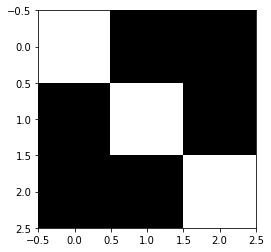

In [14]:
i = np.identity(3)
filter1 = np.dstack([i] * 3)
plt.imshow(filter1) 
plt.show()

Aplicando las operaciones de convolución de varias imagenes del dígito $1$ con dicho filtro y variando algunos parámetros, obtenemos:

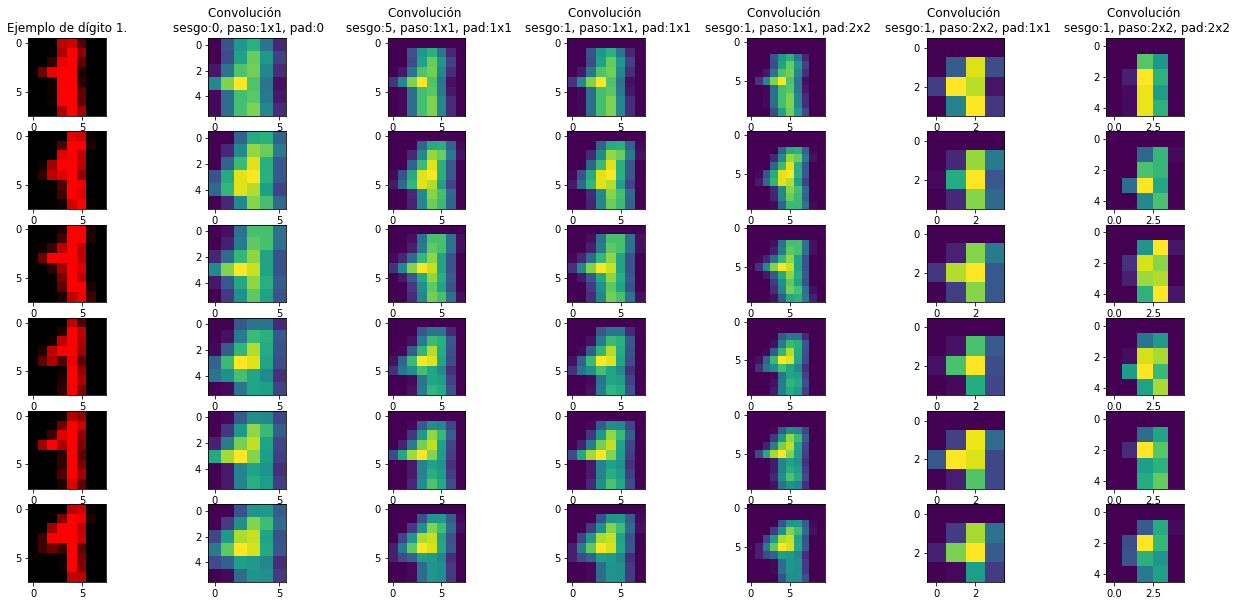

In [15]:
a_1 = convolve(reshapeToChannelFirst(data[1]), filter1, 0)
a_2 = convolve(reshapeToChannelFirst(data[3]), filter1, 0)
a_3 = convolve(reshapeToChannelFirst(data[5]), filter1, 0)
a_4 = convolve(reshapeToChannelFirst(data[8]), filter1, 0)
a_5 = convolve(reshapeToChannelFirst(data[9]), filter1, 0)
a_6 = convolve(reshapeToChannelFirst(data[13]), filter1, 0)

b_1 = convolve(reshapeToChannelFirst(data[1]), filter1, 1,1,1)
b_2 = convolve(reshapeToChannelFirst(data[3]), filter1, 1,1,1)
b_3 = convolve(reshapeToChannelFirst(data[5]), filter1, 1,1,1)
b_4 = convolve(reshapeToChannelFirst(data[8]), filter1, 1,1,1)
b_5 = convolve(reshapeToChannelFirst(data[9]), filter1, 1,1,1)
b_6 = convolve(reshapeToChannelFirst(data[13]), filter1, 1,1,1)

c_1 = convolve(reshapeToChannelFirst(data[1]), filter1, 1,1,2)
c_2 = convolve(reshapeToChannelFirst(data[3]), filter1, 1,1,2)
c_3 = convolve(reshapeToChannelFirst(data[5]), filter1, 1,1,2)
c_4 = convolve(reshapeToChannelFirst(data[8]), filter1, 1,1,2)
c_5 = convolve(reshapeToChannelFirst(data[9]), filter1, 1,1,2)
c_6 = convolve(reshapeToChannelFirst(data[13]), filter1, 1,1,2)

d_1 = convolve(reshapeToChannelFirst(data[1]), filter1, 1,2,1)
d_2 = convolve(reshapeToChannelFirst(data[3]), filter1, 1,2,1)
d_3 = convolve(reshapeToChannelFirst(data[5]), filter1, 1,2,1)
d_4 = convolve(reshapeToChannelFirst(data[8]), filter1, 1,2,1)
d_5 = convolve(reshapeToChannelFirst(data[9]), filter1, 1,2,1)
d_6 = convolve(reshapeToChannelFirst(data[13]), filter1, 1,2,1)

e_1 = convolve(reshapeToChannelFirst(data[1]), filter1, 1,2,2)
e_2 = convolve(reshapeToChannelFirst(data[3]), filter1, 1,2,2)
e_3 = convolve(reshapeToChannelFirst(data[5]), filter1, 1,2,2)
e_4 = convolve(reshapeToChannelFirst(data[8]), filter1, 1,2,2)
e_5 = convolve(reshapeToChannelFirst(data[9]), filter1, 1,2,2)
e_6 = convolve(reshapeToChannelFirst(data[13]), filter1, 1,2,2)

f_1 = convolve(reshapeToChannelFirst(data[1]), filter1, 5,1,1)
f_2 = convolve(reshapeToChannelFirst(data[3]), filter1, 5,1,1)
f_3 = convolve(reshapeToChannelFirst(data[5]), filter1, 5,1,1)
f_4 = convolve(reshapeToChannelFirst(data[8]), filter1, 5,1,1)
f_5 = convolve(reshapeToChannelFirst(data[9]), filter1, 5,1,1)
f_6 = convolve(reshapeToChannelFirst(data[13]), filter1, 5,1,1)

fig, axs = plt.subplots(6, 7, figsize=(22, 10))
axs[0,0].imshow(data[1])
axs[0,0].set_title('Ejemplo de dígito 1.')
axs[0,1].imshow(a_1)
axs[0,2].imshow(f_1)
axs[0,3].imshow(b_1)
axs[0,4].imshow(c_1)
axs[0,5].imshow(d_1)
axs[0,6].imshow(e_1)

axs[0,1].set_title('Convolución \n sesgo:0, paso:1x1, pad:0')
axs[0,2].set_title('Convolución \n sesgo:5, paso:1x1, pad:1x1')
axs[0,3].set_title('Convolución \n sesgo:1, paso:1x1, pad:1x1')
axs[0,4].set_title('Convolución \n sesgo:1, paso:1x1, pad:2x2')
axs[0,5].set_title('Convolución \n sesgo:1, paso:2x2, pad:1x1')
axs[0,6].set_title('Convolución \n sesgo:1, paso:2x2, pad:2x2')


axs[1,0].imshow(data[3])
axs[1,1].imshow(a_2)
axs[1,2].imshow(f_2)
axs[1,3].imshow(b_2)
axs[1,4].imshow(c_2)
axs[1,5].imshow(d_2)
axs[1,6].imshow(e_2)


axs[2,0].imshow(data[5])
axs[2,1].imshow(a_3)
axs[2,2].imshow(f_3)
axs[2,3].imshow(b_3)
axs[2,4].imshow(c_3)
axs[2,5].imshow(d_3)
axs[2,6].imshow(e_3)

axs[3,0].imshow(data[8])
axs[3,1].imshow(a_4)
axs[3,2].imshow(f_4)
axs[3,3].imshow(b_4)
axs[3,4].imshow(c_4)
axs[3,5].imshow(d_4)
axs[3,6].imshow(e_4)

axs[4,0].imshow(data[9])
axs[4,1].imshow(a_5)
axs[4,2].imshow(f_5)
axs[4,3].imshow(b_5)
axs[4,4].imshow(c_5)
axs[4,5].imshow(d_5)
axs[4,6].imshow(e_5)

axs[5,0].imshow(data[13])
axs[5,1].imshow(a_6)
axs[5,2].imshow(f_6)
axs[5,3].imshow(b_6)
axs[5,4].imshow(c_6)
axs[5,5].imshow(d_6)
axs[5,6].imshow(e_6)

plt.show()

Aplicando las operaciones de convolución de varias imagenes del dígito $0$ con dicho filtro y variando algunos parámetros, obtenemos:

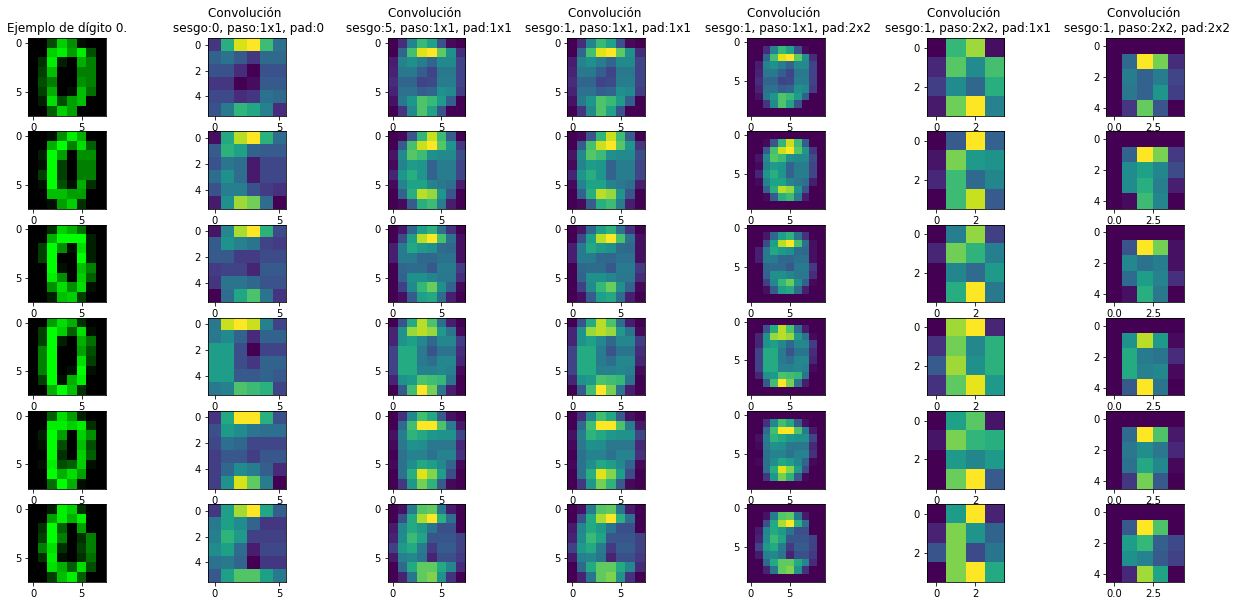

In [16]:
a_1 = convolve(reshapeToChannelFirst(data[0]), filter1, 0)
a_2 = convolve(reshapeToChannelFirst(data[2]), filter1, 0)
a_3 = convolve(reshapeToChannelFirst(data[4]), filter1, 0)
a_4 = convolve(reshapeToChannelFirst(data[6]), filter1, 0)
a_5 = convolve(reshapeToChannelFirst(data[7]), filter1, 0)
a_6 = convolve(reshapeToChannelFirst(data[10]), filter1, 0)

b_1 = convolve(reshapeToChannelFirst(data[0]), filter1, 1,1,1)
b_2 = convolve(reshapeToChannelFirst(data[2]), filter1, 1,1,1)
b_3 = convolve(reshapeToChannelFirst(data[4]), filter1, 1,1,1)
b_4 = convolve(reshapeToChannelFirst(data[6]), filter1, 1,1,1)
b_5 = convolve(reshapeToChannelFirst(data[7]), filter1, 1,1,1)
b_6 = convolve(reshapeToChannelFirst(data[10]), filter1, 1,1,1)

c_1 = convolve(reshapeToChannelFirst(data[0]), filter1, 1,1,2)
c_2 = convolve(reshapeToChannelFirst(data[2]), filter1, 1,1,2)
c_3 = convolve(reshapeToChannelFirst(data[4]), filter1, 1,1,2)
c_4 = convolve(reshapeToChannelFirst(data[6]), filter1, 1,1,2)
c_5 = convolve(reshapeToChannelFirst(data[7]), filter1, 1,1,2)
c_6 = convolve(reshapeToChannelFirst(data[10]), filter1, 1,1,2)

d_1 = convolve(reshapeToChannelFirst(data[0]), filter1, 1,2,1)
d_2 = convolve(reshapeToChannelFirst(data[2]), filter1, 1,2,1)
d_3 = convolve(reshapeToChannelFirst(data[4]), filter1, 1,2,1)
d_4 = convolve(reshapeToChannelFirst(data[6]), filter1, 1,2,1)
d_5 = convolve(reshapeToChannelFirst(data[7]), filter1, 1,2,1)
d_6 = convolve(reshapeToChannelFirst(data[10]), filter1, 1,2,1)

e_1 = convolve(reshapeToChannelFirst(data[0]), filter1, 1,2,2)
e_2 = convolve(reshapeToChannelFirst(data[2]), filter1, 1,2,2)
e_3 = convolve(reshapeToChannelFirst(data[4]), filter1, 1,2,2)
e_4 = convolve(reshapeToChannelFirst(data[6]), filter1, 1,2,2)
e_5 = convolve(reshapeToChannelFirst(data[7]), filter1, 1,2,2)
e_6 = convolve(reshapeToChannelFirst(data[10]), filter1, 1,2,2)

f_1 = convolve(reshapeToChannelFirst(data[0]), filter1, 5,1,1)
f_2 = convolve(reshapeToChannelFirst(data[2]), filter1, 5,1,1)
f_3 = convolve(reshapeToChannelFirst(data[4]), filter1, 5,1,1)
f_4 = convolve(reshapeToChannelFirst(data[6]), filter1, 5,1,1)
f_5 = convolve(reshapeToChannelFirst(data[7]), filter1, 5,1,1)
f_6 = convolve(reshapeToChannelFirst(data[10]), filter1, 5,1,1)

fig, axs = plt.subplots(6, 7, figsize=(22, 10))
axs[0,0].imshow(data[0])
axs[0,0].set_title('Ejemplo de dígito 0.')
axs[0,1].imshow(a_1)
axs[0,2].imshow(f_1)
axs[0,3].imshow(b_1)
axs[0,4].imshow(c_1)
axs[0,5].imshow(d_1)
axs[0,6].imshow(e_1)

axs[0,1].set_title('Convolución \n sesgo:0, paso:1x1, pad:0')
axs[0,2].set_title('Convolución \n sesgo:5, paso:1x1, pad:1x1')
axs[0,3].set_title('Convolución \n sesgo:1, paso:1x1, pad:1x1')
axs[0,4].set_title('Convolución \n sesgo:1, paso:1x1, pad:2x2')
axs[0,5].set_title('Convolución \n sesgo:1, paso:2x2, pad:1x1')
axs[0,6].set_title('Convolución \n sesgo:1, paso:2x2, pad:2x2')


axs[1,0].imshow(data[2])
axs[1,1].imshow(a_2)
axs[1,2].imshow(f_2)
axs[1,3].imshow(b_2)
axs[1,4].imshow(c_2)
axs[1,5].imshow(d_2)
axs[1,6].imshow(e_2)


axs[2,0].imshow(data[4])
axs[2,1].imshow(a_3)
axs[2,2].imshow(f_3)
axs[2,3].imshow(b_3)
axs[2,4].imshow(c_3)
axs[2,5].imshow(d_3)
axs[2,6].imshow(e_3)

axs[3,0].imshow(data[6])
axs[3,1].imshow(a_4)
axs[3,2].imshow(f_4)
axs[3,3].imshow(b_4)
axs[3,4].imshow(c_4)
axs[3,5].imshow(d_4)
axs[3,6].imshow(e_4)

axs[4,0].imshow(data[7])
axs[4,1].imshow(a_5)
axs[4,2].imshow(f_5)
axs[4,3].imshow(b_5)
axs[4,4].imshow(c_5)
axs[4,5].imshow(d_5)
axs[4,6].imshow(e_5)

axs[5,0].imshow(data[10])
axs[5,1].imshow(a_6)
axs[5,2].imshow(f_6)
axs[5,3].imshow(b_6)
axs[5,4].imshow(c_6)
axs[5,5].imshow(d_6)
axs[5,6].imshow(e_6)

plt.show()

En los experimentos anterirores se puede observar que al aumentar el paso, se comienza a perder información de la imagen, esto es debido a que las imagenes no contienen mucha información y el filtro es de tamaño considerable en comparación al tamaño de la matriz de la imagen, entonces al aumentar el paso aunque sea a dos, se pierde información de la imagen. 
Por el contrario cuando se le aumenta padding la convolución captura mas información de la imagen. 

Podemos definir otros filtros de $3\times 3$:

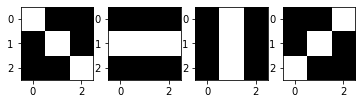

In [17]:
indentity = np.identity(3)
filters = np.zeros((4, 3, 3))
filters[0, :, :] = indentity
filters[1, 1, :] = 1
filters[2, :, 1] = 1
filters[3, :, :] = indentity[::-1]

filt_1 = np.dstack([filters[0]] * 3)
filt_2 = np.dstack([filters[1]] * 3)
filt_3 = np.dstack([filters[2]] * 3)
filt_4 = np.dstack([filters[3]] * 3)

W = np.array([filt_1,filt_2,filt_3,filt_4])

plt.subplot(1,4,1)
plt.imshow(W[0]) 
plt.subplot(1,4,2)
plt.imshow(W[1]) 
plt.subplot(1,4,3)
plt.imshow(W[2]) 
plt.subplot(1,4,4)
plt.imshow(W[3]) 
plt.show()

Se utiliza la funcion anteriormente definida para aplicar la convolución en las imágenes utilizando multiples filtros:

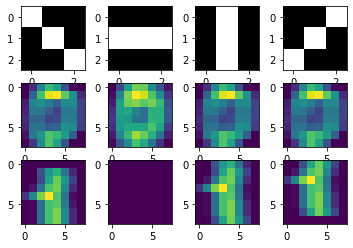

In [18]:
#Se define un sesgo por cada filtro
b = [1,1,1,1]
a_0 = convolve(reshapeToChannelFirst(data[0]), W, b, 1, 1)
a_1 = convolve(reshapeToChannelFirst(data[1]), W, b, 1, 1)

for i in range(4):
  plt.subplot(3,4,i + 1)
  plt.imshow(W[i])
  plt.subplot(3,4,i + 5)
  plt.imshow(a_0[i])
  plt.subplot(3,4,i + 9)
  plt.imshow(a_1[i])

Al realizar distintas pruebas variando los parámetros para la convolución se observa que puede ayudar significativamente a los modelos de clasificación.
Así como los parámetros son importantes también el filtro que se ocupa influye bastante en la convolución, por ejemplo, en la última prueba que se realizó utilizando múltiples filtros, el segundo filtro utilizado no ayudó para nada debido a que la imagen utilizada es color rojo y el filtro solo tenía valores en el segundo canal, entonces todos los valores se hicieron 0 y no ayuda nada.

Esto me ayuda bastante en el proyecto de tesis debido a que estoy trabajando con redes basadas en grafos utilizando convolución para extracción de características estilísticas de los diferentes autores de textos, entonces es interesante como se pueden aplicar estos métodos tanto para imagenes como para textos.
